## Intro to Decision Trees 

Class,

An important class of Supervised learning models and algorithms, both for Classification and for Regression, are **Decision trees** (henceforth, D-trees).  

Below, we explore what they are, how they work, capabilities and limitations as well as a few use-cases on business datasets.

Again, following old policy, we start with a dummy dataset and apply the simplest models to it - for intuition of inner working. Gradually, we scale up data size and model complexity.

Let's start with the setup chunk. Behold.

In [1]:
## setup chunk

# sklearn imports
from sklearn.tree import DecisionTreeClassifier  # Dtree classifn
from sklearn.tree import DecisionTreeRegressor   # Dtree regressn
from sklearn.linear_model import LinearRegression  # for comparison

from sklearn.datasets import make_moons  # to simulate dummy data
from sklearn.model_selection import train_test_split  

# utils
import numpy as np
import pandas as pd
import time
import os

# plotting
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import graphviz
import mglearn

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
## Concept: How Decision Trees Work - Intuition via Visualization
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)
print("Xm sample:\n", Xm[:5,:])
print("\n")
print("ym sample: ", ym[:5])

Xm sample:
 [[ 0.20706864  0.98150398]
 [ 1.16289446  0.01844799]
 [ 0.1426683  -0.1109168 ]
 [ 1.1326334   0.26763099]
 [ 0.52544099 -0.32757822]]


ym sample:  [0 1 1 0 1]


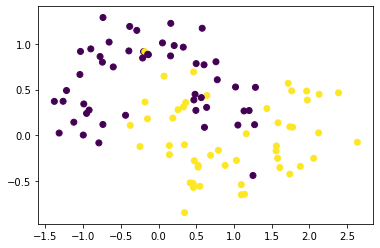

In [5]:
# plot n view data pattern
plt.scatter(Xm[:,0], Xm[:,1], c=ym)  

If you could *only* use vertical or horizontal lines to *cut* the above figure, how many cuts would you take to isolate & separate the purples from the yellows?

Why only vertical or horiz? Because a d-tree *splits* the sample one variable at a time. 

We'll visualize and see this in action but first, some results. 

In [7]:
# fit an UNRESTRICTED D-Tree classifiers on it
deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf1.fit(Xm, ym)
print("Accuracy on Unrestricted Tree: ", round(deep_tree_clf1.score(Xm, ym), 3))   # 1.000

Accuracy on Unrestricted Tree:  1.0


In [8]:
# D-tree below restricts each leaf node to have 4+ instances
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf2.fit(Xm, ym)
print("Accuracy on Restricted Tree:", round(deep_tree_clf2.score(Xm, ym), 3))   # 0.960

Accuracy on Restricted Tree: 0.96


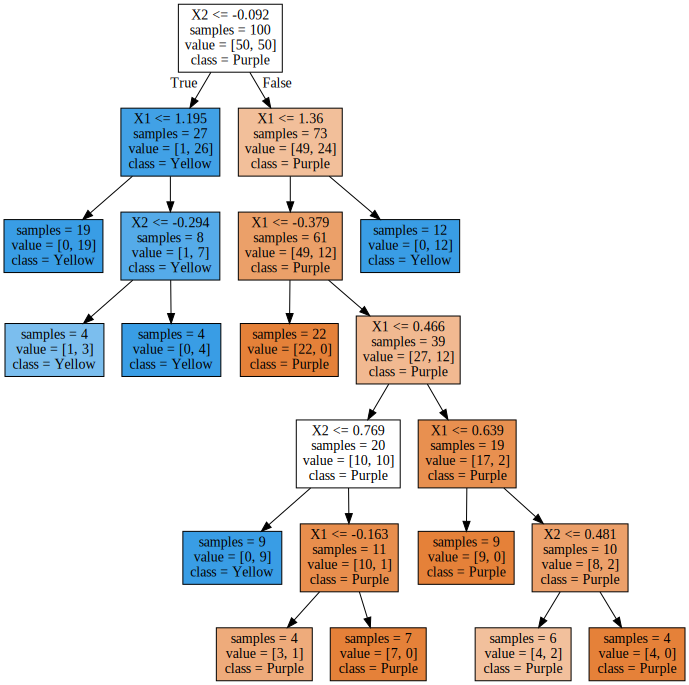

In [10]:
## build D-tree itself and see
from sklearn.tree import export_graphviz
export_graphviz(deep_tree_clf2,    # fitted model here
                out_file="tree.dot", 
                class_names=["Purple", "Yellow"],  # user input here
                feature_names = ['X1', 'X2'],      # user input here
                impurity=False, filled=True)

# display the tree with graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

Again, the top node is the 'root node' from which uccssive binary branching leads to the terminal nodes a.k.a *leaf nodes*. The node boxes are shaded as per their subsample *purity* (darker shade means more pure).

Compare the tree above with the plotted data pattern. Trace each branch in the tree with corresponding dot locations on the plot. 

Its easy to see how the machine is building rectangular 'zones' of *pure* samples. How the model selects a zone i.e. where to split what variable comes from information theory (Maximum Entropy principle).

### Visualizing the intuition of D-trees

Below, we will formalize the pattern above in terms of cuts and rectangular zones, both for the unrestricted tree and for the constrained one. 

But first, since I intend to draw more than one plot, let me write a function that'll automate the slog of building a plot everytime. Behold below the custom function *plot_decision_boundary()* that takes the fitted tree model as input and outputs the cuts the model made and the resulting rectangular zones.

In [11]:
# def func to draw Dtree decision boundaries.
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], legend=False, plot_training=True):
    
    x1s = np.linspace(axes[0], axes[1], 100)  # akin to seq(start, stop, num_breaks)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    # plot contour maps, select colors from custom palettes
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
        
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
    if legend:
        plt.legend(loc="lower right", fontsize=14)

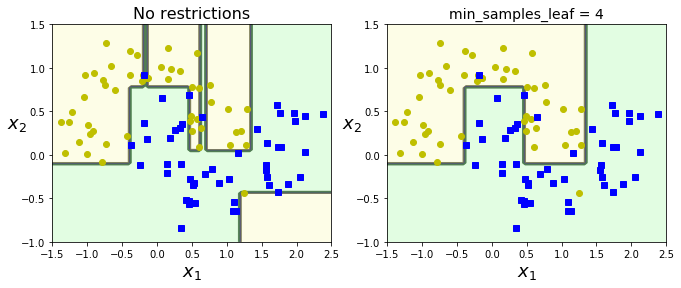

In [12]:
## Now plot DTree action in both cases & compare
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5])
plt.title("No restrictions", fontsize=16)

# plt.figure(figsize=(11, 4))
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5])
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

# save_fig("min_samples_leaf_plot")
plt.show()

Well, whatddya think? 

Recall that in the Unrestricted tree model, we obtained a classification accuracy of 100%. See the left figure above and its no hard to see why that happened, eh? Classic case of what in ML we call *overfitting*, an old enemy of ML researchers.

Note also what happens when we constrain the model to have a minimum leaf_size. Classification accuracy seems to fall (of course) but overfitting risk is much lower and hence generalizability chances to fresh, unseen data are so much better now. Only.

P.S. There're other ways to constrain D-trees. We can mandate that trees be only so many levels deep etc. 
 
But before I go there, an important note about capabilities and limitations. We'll see what the *form of data representation* can do to model performance. 

### Rotating Data & Impact on Tree Performance

What happens when the *same* data presented to the d-tree algo is re-presented with some basic transformations. Note, the data remain the same but because representation changed (in this case, axis alignment), it affects model performance.

Behold.

Xs vals: 
 [[ 0.39286015 -0.16802019]
 [ 0.32122912 -0.45830337]
 [-0.39234332  0.09505206]
 [ 0.02981736 -0.08119257]
 [-0.16459215  0.12251943]
 [-0.06185857  0.23588211]
 [ 0.01803641  0.0788586 ]
 [ 0.1453551   0.49022427]]



ys vals:  [2. 2. 0. 2. 0. 0. 2. 2.]


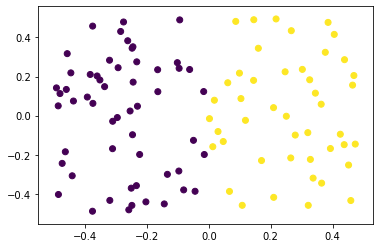

In [14]:
## Concept: sensitivity to rotation of tree methods

# simulating dummy data to demo the concept
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5; print("Xs vals: \n", Xs[:8,:])
print("\n\n")
ys = (Xs[:, 0] > 0).astype(np.float32) * 2;  print("ys vals: ", ys[:8])

# view data pattern
plt.scatter(Xs[:,0], Xs[:,1], c=ys)

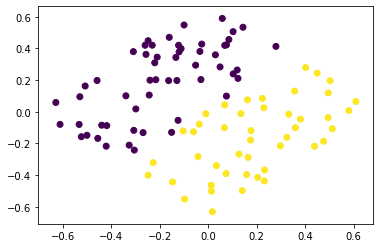

In [15]:
# 'rotate' the current data representation
angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

plt.scatter(Xsr[:,0], Xsr[:,1], c=ys)  # view rotated representation

In [16]:
# now fit DTree on both original & rotated data representations
tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)

tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

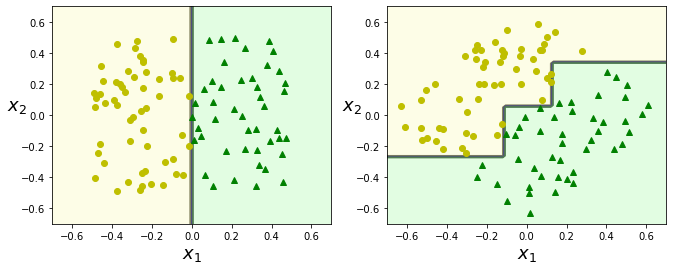

In [17]:
# Now plot DTree performance on both representations
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7])
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7])

# save_fig("sensitivity_to_rotation_plot")
plt.show()

### Analyzing the Titanic Dataset

Time now to head to a real world as opposed to simulated application (albeit non-business). I'll head to the slides to explain the manin variables.  See below.

In [18]:
## Analyze Titanic data with Dtree Classifn.
read_path = "C:/Users/20052/Dropbox/teaching related/MLBM/"  # put your own filepath here
titanic = pd.read_csv(read_path + "Titanic.csv")
print(titanic.shape, "\n", titanic.columns)
titanic.head()  # view a few rows

(712, 8) 
 Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2
1,1,1,1,38.0,1,0,71.2833,0
2,1,3,1,26.0,0,0,7.9250,2
3,1,1,1,35.0,1,0,53.1000,2
4,0,3,0,35.0,0,0,8.0500,2


In [19]:
y = titanic['Survived']  # outcome label
X = titanic.iloc[:,1:8]  # input variables

# split into training and test subsamples
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [20]:
# instantiate tree classifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)  # fit model to data
print("Accuracy on training set: ", round(tree.score(X_train, y_train), 3))  # 0.989
print("Accuracy on test set: ", round(tree.score(X_test, y_test), 3))   # 0.781

Accuracy on training set:  0.989
Accuracy on test set:  0.781


Uh-oh. Look at the big difference between train and test classification accuracy. Clearly, overfitting happening. 

Remember, we care more about classifier's performance in test data rather than training data, because of *generalizability* concerns. So how then to bump up the accuracy in the test sample? 

One option is to constrain the tree to mitigate overfitting and improve generlaizable performance in test sample. See below.

In [25]:
# prune tree with 'max_depth' against overfitting & for better generalizn
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: ", round(tree.score(X_train, y_train), 3))   # 0.826
print("Accuracy on test set: ", round(tree.score(X_test, y_test), 3))    # 0.860

Accuracy on training set:  0.826
Accuracy on test set:  0.86


Well, look at that. The wonders of constraining a model for *simplicity* and hence generalizability. 

The test sample accuracy jumps to 86% now, higher in fact than even the training sample accuracy of 82.6%.

#### Visualizing the Titanic D-tree

Let's visualize the titanic wala d-tree and after that, see which variables are most important and why.

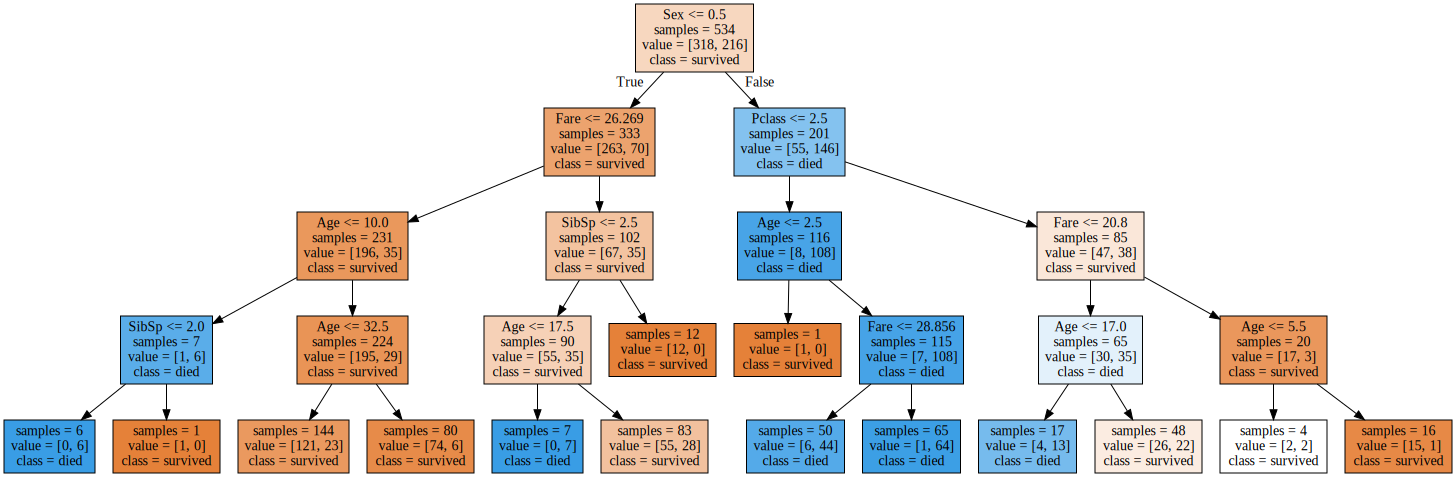

In [22]:
## Analyzing Decision Trees
from sklearn.tree import export_graphviz
export_graphviz(tree, 
                out_file="tree.dot", 
                class_names=["survived", "died"],
                feature_names = X.columns, impurity=False, filled=True)

# display the tree with graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

Analyze the tree. Trace branches of interest to leaf nodes of interest. Note the concept of 'recursive partitioning' - that is the same variable splits at multiple levels.

A manager, ever practical, would likely ask - "So what can a d-tree do for me?"

A look at the results might be instructive. Recall how we defined supervised learning? As a model-discovered function that connects multiple inputs to (binary) outcomes in classification tasks.

So which inputs contributed how much to classification? Armed with that info, a manager could always drill down to a handful of variables or features of interest. 

See below.

### Assessing Feature Importance

In [23]:
# print("Feature importances: ", tree.feature_importances_)
feat_imp_df = pd.DataFrame({'variable': X.columns, 'imp_score':tree.feature_importances_})
feat_imp_df.sort_values(by = 'imp_score', ascending=False)

,variable,imp_score
1,Sex,0.538425
0,Pclass,0.185263
2,Age,0.152583
5,Fare,0.084090
3,SibSp,0.039639
4,Parch,0.000000
6,Embarked,0.000000


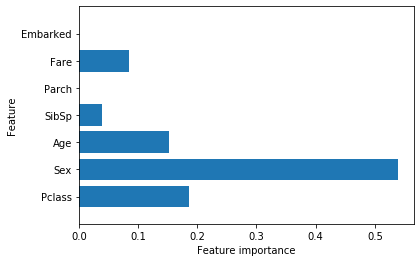

In [24]:
# plot as bar-chart too
def plot_feature_importances(model, X):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(tree, X)

Back to the slides at this stage.

Voleti